In [29]:
# pip install tensorflow
# pip install yfinance
# pip install tensorflow.keras

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [31]:
# --- 1. DATA FETCHING ---
symbol = input("Enter the stock symbol (e.g., RELIANCE.NS, ^NSEI): ")
print(f"Fetched data for '{symbol}' using yfinance...")

Enter the stock symbol (e.g., RELIANCE.NS, ^NSEI): ^NSEI
Fetched data for '^NSEI' using yfinance...


In [32]:
try:
    # Create a Ticker object
    sym_data = yf.Ticker(symbol)

    # Fetch historical market data (1 year of daily data)
    data = sym_data.history(period="6mo", interval="1d")

    if data.empty:
        raise ValueError(
            f"No data found for symbol '{symbol}'. Please check the ticker."
        )

    # Reset index to make 'Date' a column and keep it as datetime objects
    data = data.reset_index()

    # Select and rename columns for clarity
    data = data[["Date", "Open", "High", "Low", "Close"]]
    data["Date"] = pd.to_datetime(data["Date"])
    # Then format to dd-mm-yyyy
    data["Date"] = data["Date"].dt.strftime("%d-%m-%Y")
    print("\nSuccessfully fetched data. Here are the last 5 data points:")
    print(data.tail().round(2))

except Exception as e:
    print(f"\nAn error occurred: {e}")


Successfully fetched data. Here are the last 5 data points:
           Date      Open      High       Low     Close
244  25-08-2025  24949.15  25021.55  24894.35  24967.75
245  26-08-2025  24899.50  24919.65  24689.60  24712.05
246  28-08-2025  24695.80  24702.65  24481.60  24500.90
247  29-08-2025  24466.70  24572.45  24404.70  24426.85
248  01-09-2025  24432.70  24635.60  24432.70  24625.05


In [33]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T.round(2))

summary statistics  
        count      mean     std       min       25%       50%       75%  \
Open   249.0  24267.55  928.88  21758.40  23543.80  24432.70  24996.20   
High   249.0  24381.58  915.73  22105.05  23689.85  24585.50  25070.00   
Low    249.0  24140.34  932.21  21743.65  23433.50  24337.50  24852.85   
Close  249.0  24257.96  920.63  22082.65  23532.70  24461.15  24967.75   

            max  
Open   26248.25  
High   26277.35  
Low    26151.40  
Close  26216.05  


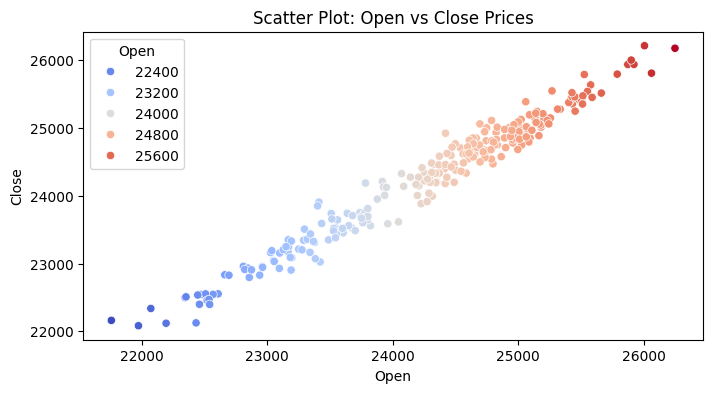

In [34]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

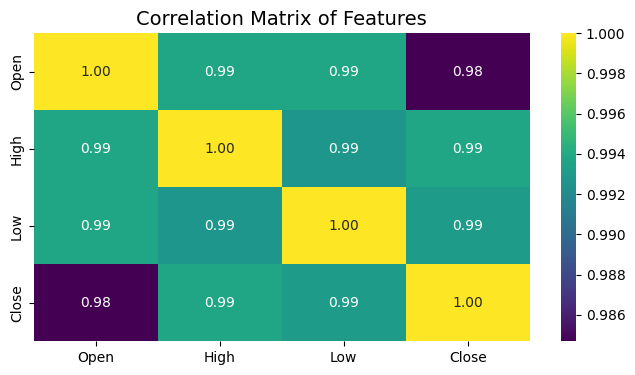

In [35]:
# Heatmap for visualizing correlations
plt.figure(figsize=(8, 4))
numeric_cols = data.select_dtypes(include=np.number)
sb.heatmap(numeric_cols.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title("Correlation Matrix of Features", fontsize=14)
plt.show()

In [36]:
from scipy.stats import skew
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))

Skewness (Close): -0.4094515557249295
Skewness (Open): -0.4579940598485677
Skewness (High): -0.45935248485515984
Skewness (Low): -0.39478871579373254


In [37]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [38]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
print(data.tail())

Overview of dataset after adding some features 


           Date      Open      High       Low     Close  Trend
244  25-08-2025  24949.15  25021.55  24894.35  24967.75      0
245  26-08-2025  24899.50  24919.65  24689.60  24712.05      0
246  28-08-2025  24695.80  24702.65  24481.60  24500.90      0
247  29-08-2025  24466.70  24572.45  24404.70  24426.85      1
248  01-09-2025  24432.70  24635.60  24432.70  24625.05      0


In [39]:
# We will use 'Open', 'High', 'Low', 'Close' as features
features = ["Open", "High", "Low", "Close"]
# data_to_scale = data['Close']
data_to_scale = data[features]

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data_to_scale)
scaled_data = scaler.fit_transform(data_to_scale.to_numpy().reshape(-1, 1))

In [40]:
# Function to create sequences of data
def create_sequences(dataset, time_steps=60):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        # Sequence of 'time_steps' length
        X.append(dataset[i : (i + time_steps), :])
        # The target is the 'Close' price of the next day
        # Corrected line
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)


# Define the number of time steps (days) to look back
time_steps = 120
X, y = create_sequences(scaled_data, time_steps)

In [41]:
# Split data into training and testing sets
train_size = int(len(X) * 0.70)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (613, 120, 1), Training labels shape: (613,)
Testing data shape: (263, 120, 1), Testing labels shape: (263,)


In [42]:
# --- 4. BUILD AND TRAIN THE LSTM MODEL ---
model = Sequential()
# Layer 1
model.add(
    LSTM(
        units=100,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
model.add(Dropout(0.2))
# Layer 2
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
# Layer 3
model.add(LSTM(units=100))
model.add(Dropout(0.2))
# Output Layer
model.add(Dense(units=1))  # Predicting one value: the next day's price

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

print("\nTraining the model...")
history = model.fit(
    X_train,
    y_train,
    epochs=55,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
)
print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 120, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 120, 50)        │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 120, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,501 (513.68 KB)

 Trainable params: 131,501 (513.68 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: 0.0877 - val_loss: 0.0644
Epoch 2/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.0184 - val_loss: 0.0105
Epoch 3/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.0095 - val_loss: 0.0034
Epoch 4/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - loss: 0.0080 - val_loss: 0.0109
Epoch 5/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 6/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 7/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 8/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 9/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 10/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 11/55
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 12/55
10/10 ━━━━━━━━━━━

In [43]:
# --- EVALUATE THE MODEL ---
# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

# Reshape y_test from a 1D array to a 2D array for the scaler
y_test = y_test.reshape(-1, 1)

# Inverse transform directly. No complex placeholders are needed for a single feature.
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# 5. Calculate performance metrics
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2) Score: {r2:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 150.36
Mean Absolute Error (MAE): 117.54
R-squared (R2) Score: 0.7884


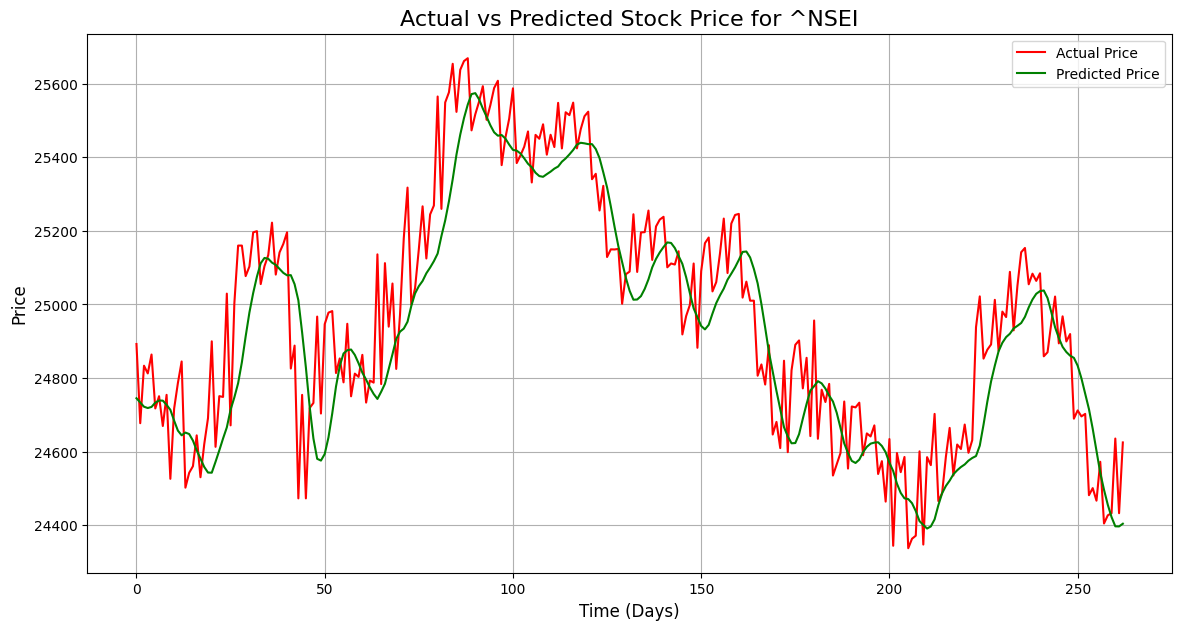

In [44]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='red', label="Actual Price")
plt.plot(y_pred, color='green', label="Predicted Price")
plt.title(f"Actual vs Predicted Stock Price for {symbol}", fontsize=16)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# --- FORECAST FUTURE PRICES ---
try:
    forecast_days = int(input("\nEnter the number of days to forecast into the future (e.g., 30): "))
    if forecast_days <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Defaulting to 30 days.")
    forecast_days = 15


Enter the number of days to forecast into the future (e.g., 30): 15


In [46]:
# Use the last 'time_steps' from the single-feature scaled data as the starting point
last_sequence = scaled_data[-time_steps:].flatten() # Start with a 1D array
forecast_predictions_scaled = []

current_input = last_sequence

print(f"\nForecasting for the next {forecast_days} days...")

for _ in range(forecast_days):
    # Reshape the current input to what the model expects: (1, time_steps, 1)
    current_input_reshaped = current_input.reshape((1, time_steps, 1))

    # Predict the next day's scaled price
    pred_scaled = model.predict(current_input_reshaped, verbose=0)[0, 0]
    forecast_predictions_scaled.append(pred_scaled)

    # Update the input sequence for the next prediction:
    # Drop the first value and append the new prediction at the end
    current_input = np.append(current_input[1:], pred_scaled)

# Inverse transform the forecast predictions (this is much simpler now)
forecast_prices = scaler.inverse_transform(np.array(forecast_predictions_scaled).reshape(-1, 1))

# --- The rest of your plotting code is correct ---

data["Date"] = pd.to_datetime(data["Date"], format="%d-%m-%Y")

# Create future dates for the forecast
last_date = data["Date"].iloc[-1]
# You may need to import timedelta: from datetime import timedelta
from datetime import timedelta
future_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]

# Create and display the forecast DataFrame
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted Close": forecast_prices.flatten()})
print("\n--- Forecasted Prices ---")
print(forecast_df.round(2))

# Plot the forecast
# plt.figure(figsize=(14, 7))
# plt.plot(data["Date"], data["Close"], label="Historical Close Price", color="royalblue")
# plt.plot(
#     forecast_df["Date"],
#     forecast_df["Predicted Close"],
#     label="Forecasted Close Price",
#     color="orange",
#     linestyle="--",
# )
# plt.title("Price Forecast", fontsize=16)
# plt.xlabel("Date", fontsize=12)
# plt.ylabel("Price", fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.show()


Forecasting for the next 15 days...

--- Forecasted Prices ---
         Date  Predicted Close
0  2025-09-02     24427.000000
1  2025-09-03     24446.080078
2  2025-09-04     24456.859375
3  2025-09-05     24459.910156
4  2025-09-06     24457.460938
5  2025-09-07     24451.689453
6  2025-09-08     24444.179688
7  2025-09-09     24435.839844
8  2025-09-10     24427.119141
9  2025-09-11     24418.189453
10 2025-09-12     24409.089844
11 2025-09-13     24399.810547
12 2025-09-14     24390.330078
13 2025-09-15     24380.669922
14 2025-09-16     24370.839844
